# REST service with model
[GITHUB](https://github.com/alexpetersburg/rest_rnn_service)

# Import libraries

In [41]:
# standart inputs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
import json
from tqdm import tqdm

# sklearn for data preprocessing and model selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.ensemble import IsolationForest

# torch for neural networks
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
# torch lightning for readability and removing a ton of boilerplate
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# fix seed for reproducibility
import random
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)

# Load dataset

In [2]:
dataset_path = os.path.join('dataset', 'ds1.csv')
dataset = pd.read_csv(dataset_path)
dataset.drop('date', axis=1, inplace=True)

# View the data and plot target
После изучения датасета был найден аномальный участок в таргете, который может помешать обучению модели. Для его удаления используется Isolation Forest Algorithm, который помечает выбросы в данных.

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
count,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,412.558413,466.191270,498.542159,1.150161e+00,1122.376617,487.107482,427.268146,522.531333,10.771032,474.921944,...,91.382642,482.137038,417.463349,451.948018,326.589842,494.145909,509.917971,93.591592,482.768671,-1.833924e+34
std,31.618688,17.762825,14.515954,9.285411e-01,35.714308,7.790535,10.746298,16.922701,0.130060,8.964280,...,6.652589,12.480993,46.146322,8.490221,2.558371,15.212624,15.227448,5.187918,20.775683,7.221883e+35
min,27.793140,409.172346,462.484312,6.119388e-11,998.123018,461.205851,379.225705,478.927232,10.137592,445.084616,...,73.968899,449.419110,15.514387,390.374057,318.882722,404.899015,473.508838,77.932461,446.752951,-3.872055e+37
25%,410.540760,455.096904,489.833896,8.990056e-01,1106.845483,482.463276,421.102176,509.576734,10.696950,469.779211,...,85.997821,473.553597,417.034060,448.272139,324.702249,483.388533,499.110743,90.999615,465.637417,2.408568e+01
50%,414.458905,464.713622,495.384221,9.986112e-01,1130.719522,487.291185,428.662999,522.186462,10.780310,475.030014,...,94.264830,483.340933,420.948190,452.806470,326.650623,490.565081,507.402927,95.575776,478.346238,2.463131e+01
75%,423.489260,479.137063,506.167696,1.126167e+00,1147.535469,492.254889,435.540503,533.072266,10.860712,479.538780,...,96.539508,490.426649,433.098795,457.659768,328.335283,506.289345,520.889804,97.062363,502.283305,2.594548e+01
max,436.268339,510.542173,545.054459,8.038391e+00,1192.557479,506.559040,446.716565,569.905794,11.675275,502.626968,...,102.805867,513.616271,446.119896,473.231904,333.392611,534.225759,543.211897,102.687414,528.846750,2.868602e+01


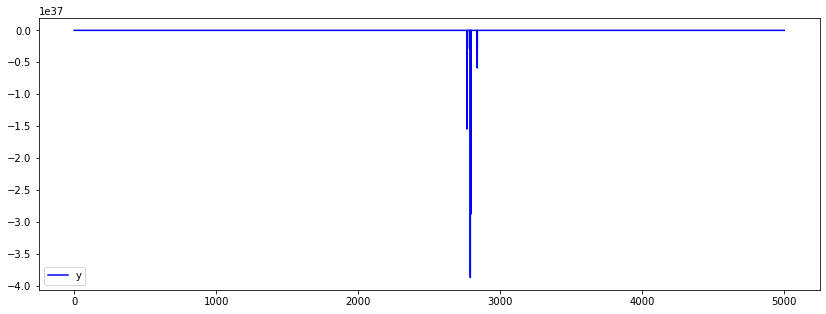

In [3]:
dataset[['y']].plot(color='blue',figsize=(14, 5))
dataset.describe()


,y
count,4850.000000
mean,25.017590
std,1.270807
min,22.058681
25%,24.126903
50%,24.655593
75%,25.961632
max,28.330009


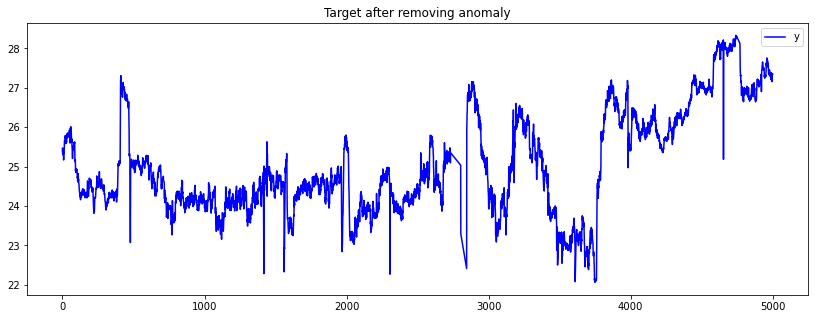

In [4]:
outler_detector = IsolationForest(contamination=0.03) # ~0.03 proportion of outliers
mask = outler_detector.fit_predict(dataset['y'].values.reshape(-1,1)) != -1 # mask with outlers
dataset =  dataset.loc[mask, :]

y_df = dataset[['y']].copy()
y_df.plot(color='blue',figsize=(14, 5), title='Target after removing anomaly')
y_df.describe()

Все еще наблюдается несколько локальных выбросов, уберем их при помощи того же Isolation Forest, искать будем по отклонению от скользящей средней с окном 10

,y
count,4801.000000
mean,25.022000
std,1.266654
min,22.058681
25%,24.129930
50%,24.656612
75%,25.961163
max,28.330009


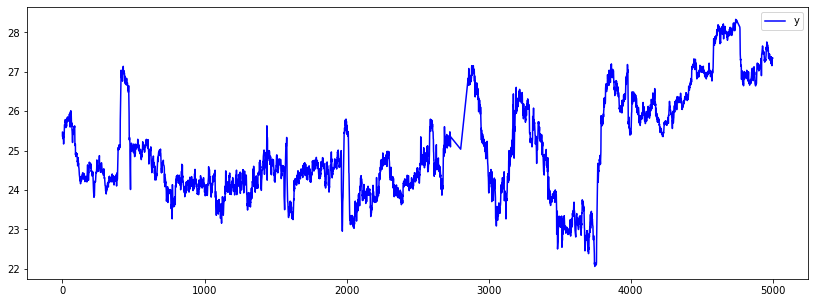

In [5]:
y_df['ma'] = y_df.rolling(10, min_periods=1).mean() # Moving average, window 10
y_df['ma_diff'] = y_df.diff(axis=1)['ma'] # difference between MA and target
outler_detector = IsolationForest(contamination=0.01) # ~0.01 proportion of outliers
mask = outler_detector.fit_predict(y_df['ma_diff'].values.reshape(-1, 1)) != -1
dataset =  dataset.loc[mask, :]  

y_df = dataset[['y']]
y_df.plot(color='blue',figsize=(14, 5))
y_df.describe()

# Normalization of a dataset
Разобьем датасет на train/test по индексам. 
Нормализируем датасет для лучшего обобщения моделью при помощи Normalizer().

In [6]:
def preprocess_train_test_data(dataset, train_ids, test_ids, preprocessing=Normalizer()):
    """
    Train/test split and normalization
    dataset:       - pd.DataFrame
    train_ids:     - array-like object
    test_ids:      - array-like object
    preprocessing: - sklearn.preprocessing
    return X_train, y_train, X_test, y_test - np.array 
    """
    train_set, test_set = dataset.values[train_ids], dataset.values[test_ids]
    X_train, y_train = train_set[:,:-1], train_set[:,-1]
    X_test, y_test = test_set[:,:-1], test_set[:,-1]

    X_train = preprocessing.fit_transform(X_train)
    X_test = preprocessing.transform(X_test)
    
    return X_train, y_train, X_test, y_test

# Neural Network Architecture
Так как данные являются временным рядом, то логичнее всего использовать рекуррентную архитектуру сети. В качестве рекуррентного блока используется LSTM как наиболее популярный.
Сама архитектура сети представляет собой блок LSTM, последний выход которого подается на вход линейному слою.
Гиперпараметрами архитектуры являются: n_features - входное количество фич (у нас 30), num_layers- количество слоев LSTM,
hidden_layer_size - размер слоя LSTM и линейного слоя.
Также гиперпараметрами обучения являются dropout и learning_rate

In [7]:
class LstmModel(LightningModule):
    '''
    PytorchLightning model, more readable than default pytorch model 
    '''
    def __init__(self, n_features, hidden_layer_size=20, num_layers=3, learning_rate=0.01, dropout=0.3, weight_decay=0.001,
                 seq_len=10, batch_size=200):
        """
        n_features:         - number of dataset features
        hidden_layer_size:  - LSTM and linear layer size
        num_layers:         - number of LSTM layers
        learning_rate:      - initial learning rate
        dropout:            - LSTM dropout
        weight_decay:       - add L2 penalty
        seq_len:            - input sequence len
        """
        super().__init__()
        self.save_hyperparameters() # save hparam in checkpoint
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.seq_len = seq_len
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, 1)
        

    def forward(self, x):
        # x (batch size, seq_len, n_features)
        y_hat, _ = self.lstm(x)  # output, (h_n, c_n)
        y_hat = self.linear(y_hat[:,-1,:])   # pass only last lstm output
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x) 
        loss = F.mse_loss(y_hat.view(-1), y) # mse as loss
        self.log('train_loss', loss) # log to tensorboard
        return {'loss': loss} # return loss to optimizer

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5,) # drop lr if monitor 
                                                                                                   # value not improving
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_mape"}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        mape = torch.abs(y - y_hat) / y # val mape loss to lr moninor and earlystop moninor
        return {'val_loss':  F.l1_loss(y_hat, y.view(-1,1)), 'val_mape': mape} # , 'val_mape': mape

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean() 
        mape = torch.flatten(torch.cat([x['val_mape'].view(-1) for x in outputs])).mean()
        self.log('val_loss', avg_loss) # log to tensorboard
        self.log('val_mape', mape) # log to tensorboard
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        mape = torch.abs(y - y_hat) / y.abs()
        return {'mape': mape}

    def test_epoch_end(self, outputs):
        outputs = torch.flatten(torch.cat([x['mape'].view(-1) for x in outputs]))
        mape = torch.sum(outputs)/ outputs.size()[0]
        self.test_result = mape.item() * 100

# torch Dataset
Для подачи данных в модель необходимо релаизовать класс Dataset. Так как модель является рекуррентной, то данные должны представлять собой последовательность размером seq_len, что также является гиперпараметром.

In [8]:
class TimeseriesDataset(Dataset):   
    '''
    Custom Dataset. 
    Return (seq_len, n_features). 
    '''
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 15):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

# Training
Пространство гиперпараметров задается при помощи ParameterGrid.
Для поиска наилучших параметров используется кросс валидация для временных рядов(TimeSeriesSplit)


In [9]:
def train_pipeline(train_loader, val_loader, params):
    """
    Train model using params
    :param train_loader: - torch.utils.data.DataLoader
    :param val_loader:   - torch.utils.data.DataLoader
    :param params:       - model hparams {"n_features":, "hidden_layer_size":, "num_layers":,
                                          "learning_rate": "dropout": "weight_decay":}
    :return:             - pytorch_lightning.Trainer
    """
    model = LstmModel(n_features=params['n_features'],
                      hidden_layer_size=params['hidden_layer_size'], 
                      num_layers=params['num_layers'],
                      dropout=params['dropout'],
                      weight_decay=params['weight_decay'],
                      seq_len=params['seq_len'],
                      batch_size=params["batch_size"])
    
    trainer = Trainer(
        max_epochs=50,
        gpus=1,
        progress_bar_refresh_rate=0,
        logger=None,
        weights_summary=None,
        auto_lr_find=True, # allows find initial lr automaticaly
        callbacks=[EarlyStopping(monitor='val_mape', patience=5)] # stop if monitor value not improving
    ) 
    lr_finder = trainer.tuner.lr_find(model, train_dataloader=train_loader, val_dataloaders=val_loader, num_training=100)
    new_lr = lr_finder.suggestion()
    model.learning_rate = new_lr
    model.hparams.learning_rate = new_lr # save lr to hparams to save in checkpoint

    trainer.fit(model, train_loader, val_loader) # training
    return trainer

# Train/test split

In [10]:
n_features = dataset.shape[1] - 1

n_folds = 5
params_grid = ParameterGrid({"seq_len": [10, 20, 30],
                             "hidden_layer_size": [20, 40, 60],
                             "num_layers":[1, 2, 3],
                             "batch_size": [200, 500, 1000],
                             "dropout": [0.3, 0.5],
                             "weight_decay": [0.01, 0.005, 0.001]})
grid_search_results = []
for params in tqdm(params_grid):
    params['n_features'] = n_features
    seq_len = params['seq_len']
    
    params_mape = []
    kfold = TimeSeriesSplit(n_splits=n_folds)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        # train_test split and normalization
        X_train, y_train, X_test, y_test = preprocess_train_test_data(dataset, train_ids, test_ids) 
        train_size = int(X_train.shape[0]*0.9) # train/val size 
        train_loader = DataLoader(TimeseriesDataset(X_train[:train_size], y_train[:train_size], seq_len), 
                                  batch_size = params["batch_size"], shuffle = True, num_workers = 0)
        val_loader = DataLoader(TimeseriesDataset(X_train[train_size:], y_train[train_size:], seq_len),
                                batch_size = 600, shuffle = False, num_workers = 0)
        test_loader = DataLoader(TimeseriesDataset(X_test, y_test, seq_len),
                                batch_size = 600, shuffle = False, num_workers = 0)
        
        trainer = train_pipeline(train_loader, val_loader, params)
        trainer.test(test_dataloaders=test_loader, verbose=False)
        params_mape.append(trainer.model.test_result)  # save mape result

    params_mape = np.mean(params_mape)  # mean mape TimeSeriesSplit result
    grid_search_results.append({**params, 'mape':params_mape})

  0%|          | 0/486 [00:00<?, ?it/s]
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Restored states from the checkpoint file at /home/user/test_task/model/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/user/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
100%|██████████| 486/486 [1:09:12<00:00,  8.54s/it]


# Best params
Лучшая средняя оценка модели MAPE на тестовых данных получилась 2.86%. 
Возьмем параметры сети при этом результате, обучим модель на всем тренировочном датасете.

In [28]:
grid_search_results = pd.DataFrame(grid_search_results)
best_params = grid_search_results.sort_values(by='mape', ascending=True).to_dict('records')[0]
grid_search_results.sort_values(by='mape', ascending=True).head(10)

,batch_size,dropout,hidden_layer_size,num_layers,seq_len,weight_decay,n_features,mape
319,500,0.5,60,3,20,0.005,30,2.866351
54,200,0.3,60,1,10,0.010,30,2.916178
68,200,0.3,60,2,20,0.001,30,2.916193
112,200,0.5,40,1,20,0.005,30,2.917769
6,200,0.3,20,1,30,0.010,30,2.945390
55,200,0.3,60,1,10,0.005,30,2.946830
44,200,0.3,40,2,30,0.001,30,2.946978
23,200,0.3,20,3,20,0.001,30,2.966987
39,200,0.3,40,2,20,0.010,30,2.968041
47,200,0.3,40,3,10,0.001,30,2.979992


In [40]:
X, y = dataset.values[:,:-1], dataset.values[:,-1]
preprocessor = Normalizer()
X = preprocessor.fit_transform(X)
train_loader = DataLoader(TimeseriesDataset(X, y, best_params["seq_len"]), 
                              batch_size = best_params['batch_size'], shuffle = True, num_workers = 0)
val_loader = DataLoader(TimeseriesDataset(X, y, best_params["seq_len"]),
                        batch_size = 1000, shuffle = False, num_workers = 0)

trainer = train_pipeline(train_loader, val_loader, best_params)
trainer.test(test_dataloaders=val_loader, verbose=False)
print(f'Train MAPE result: {trainer.model.test_result:.2}%')

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Restored states from the checkpoint file at /home/user/test_task/model/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train MAPE result: 3.8%


# Save model

In [43]:
best_model_path = os.path.join('weights', 'base_rnn.ckpt')
normalizer_path = os.path.join('weights', 'data_normalizer.pkl')
hparams_path = os.path.join('weights', 'rnn_hparams.json')

json.dump(trainer.model.hparams, open(hparams_path, 'w'), indent=2) # save hparams
trainer.save_checkpoint(best_model_path) # save model weights
joblib.dump(preprocessor, normalizer_path) # save sklearn.Normalizer 

['weights/data_normalizer.pkl']